# Assigment 1, part2  
Link to github : https://github.com/HugoCote/Assignment-1-Part-2
  
### Member of the team :  
- Srinivas Venkattaramanujam   
- Jean-Philippe Gagnon Fleury    
- Ahmadreza Godarzvandchegini   
- Hugo Côté   


In [114]:
# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

#### Some cells could require a long time to evaluate,   
to warn the user that the evaluation of one such cell is completed, it outputs a sound.

In [115]:
from IPython.display import Audio
wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
# the following command line produces sound and is used after cells that 
# require more time to execute :
Audio(wave, rate=10000, autoplay=True)

#### If you did not liked that sound, you should disable it  
By setting want_lound_warning to false.

In [132]:
want_lound_warning = False

#### To perfrom the hyper-parameters search, we use the following library  :  
It can be installed with the following command :  
- pip install sobol_seq

In [ ]:
# !pip install sobol_seq
import sobol_seq

# Assigment 1, part 2

## Import the data

In [117]:
transform = transforms.Compose( [transforms.ToTensor()] )
dl_path  = "./data_mnist"

train_set = mnist.MNIST( root = dl_path, train=True , download=True, transform = transform )
valid_set = mnist.MNIST( root = dl_path, train=False, download=True, transform = transform )

#### Display some samples

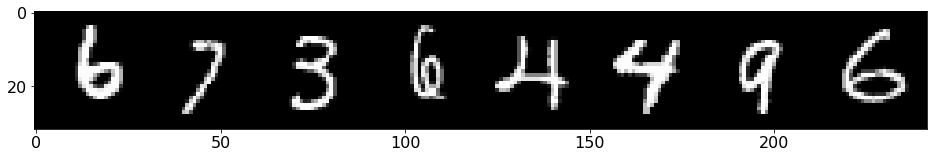

    6     7     3     6     4     4     9     6


In [119]:
nb_sample = 8

trainloader = DataLoader(train_set, batch_size = nb_sample, shuffle=True , num_workers=2)
testloader  = DataLoader(valid_set , batch_size = nb_sample, shuffle=False, num_workers=2)

# functions to show an image

def imshow(img):
    npimg = img.numpy()
    npimg = (255*npimg).astype(np.uint8) # to be a int in (0,...,255)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(nb_sample)))

#### Print the size of each dataset

In [121]:
train_dataset_size = train_set.__len__()
valid_dataset_size  = valid_set.__len__()
print( "Taining dataset size    : " , train_dataset_size )
print( "Validation dataset size : " ,valid_dataset_size )

Taining dataset size    :  60000
Validation dataset size :  10000


#### Set the device to cuda if possible

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Define some modules

### the MPL

In [123]:
class MLP(nn.Module):
    """
    MLP with 2 hidden layer
    """
    def __init__(self, h1=620,h2=620 ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 10)

    def forward(self, x):
        x = x.view( x.size()[0] , -1 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### The CNN

architecture taken from :
    https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [105]:
class CNNClassifier(nn.Module):
    """
    CNN Classifier
    """
    def __init__(self, size=472):
        self.layer_size = size
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 28^2
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 14^2 -(conv)-> 16^2 -(pool)-> 8^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 8^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4, input size = 4^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, input size = 2^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        )
        # 
        self.fct1 = nn.Linear(4*256, self.layer_size)
        self.fct2 = nn.Linear(self.layer_size,   10 )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

#### We define a function that computes the number of parameters in a model ( and displays its computation )

In [124]:
def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "Number of parameters = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth

#### Print the number of parameters in each model   
We see that the all the model have about the same number of parameters

In [130]:
list_of_models = [ MLP(), CNNClassifier() ]
nb_of_params = np.zeros(2)
for i,net in enumerate(list_of_models):
    print( net.__doc__ )
    nb_of_params[i] , _ = number_of_params( net , display_comp = True )
    
print("\nRelative difference = " , 100*abs(nb_of_params[0]-nb_of_params[1])/nb_of_params[0] , "%")


    MLP with 2 hidden layer
    
Number of parameters =  877930  =   
 (fc1.weight)             620*784
 (fc1.bias)             + 620
 (fc2.weight)           + 620*620
 (fc2.bias)             + 620
 (fc3.weight)           + 10*620
 (fc3.bias)             + 10

    CNN Classifier
    
Number of parameters =  880850  =   
 (conv.0.weight)          16*1*3*3
 (conv.0.bias)          + 16
 (conv.3.weight)        + 32*16*3*3
 (conv.3.bias)          + 32
 (conv.6.weight)        + 64*32*3*3
 (conv.6.bias)          + 64
 (conv.9.weight)        + 128*64*3*3
 (conv.9.bias)          + 128
 (conv.12.weight)       + 256*128*3*3
 (conv.12.bias)         + 256
 (fct1.weight)          + 472*1024
 (fct1.bias)            + 472
 (fct2.weight)          + 10*472
 (fct2.bias)            + 10

Relative difference =  0.3326005490187145 %


#### Test a model  
To see that there is no bug and that its output has the desired shape

In [131]:
cudanet = CNNClassifier()
_ = cudanet.to(device)
nb_sample = 2
train_loader = DataLoader(train_set, batch_size = nb_sample, shuffle=True , num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cudanet.parameters(), lr=0.00075, momentum=0, weight_decay=0)
want_to_test = False
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # if using BCE
            # labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cudanet(inputs)
            loss = criterion(outputs, labels)
            
            print( outputs.size() , labels.size() )
            print( loss )

            break

torch.Size([2, 10]) torch.Size([2])
tensor(2.3214, device='cuda:0')


### Training and measuring accuracy algorithms  
with some decorators  

In [134]:
# make sound once done, should only be used to wrap a function that returns nothing 
def make_sound(func):
    def wrapper_make_sound(*args, **kwargs):
        func(*args, **kwargs)
        wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
        audio = Audio(wave, rate=10000, autoplay=True)
        if want_lound_warning :
            return audio
    return wrapper_make_sound

# measure time with cuda events
def display_timer(func):
    def wrapper_display_timer(*args, **kwargs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        res = func(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        print( "Time required = " , start.elapsed_time(end)*0.001 , " s ")
        return res
    return wrapper_display_timer
    
@make_sound
@display_timer
def training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, state_dict_list ):
    correct      = torch.tensor([0], device = device)
    total        = torch.tensor([0], device = device) 
    running_loss = torch.tensor([0.0], dtype=torch.float, device = device) 
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute the correctness of the output labels
            with torch.no_grad() :
                _, predicted = torch.max(outputs.data, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum()

            # print statistics
            running_loss += loss.item()
        else : # print every epoch
            avg_loss[epoch]   = running_loss / i
            accuracy[epoch,0] = 100 * correct.float() / total.float()
            correct       = torch.tensor([0], device = device)
            total         = torch.tensor([0], device = device) 
            running_loss  = torch.tensor([0,0], dtype=torch.float, device = device) 
            print( 'epoch = %3d, loss = %.6f , accuracy = %4f' 
                          % (epoch + 1, avg_loss[epoch], accuracy[epoch,0] )
                 ) 
            # save the current model's state_dictionnary
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in net.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()

    else : 
        print('Finished Training')
        
# measure accuracy of a single net, returns the accuracy
def measure_single_accuracy( net, loader ):
    accuracy = 0
    with torch.no_grad():
        correct = torch.tensor([0], device=device)
        total   = torch.tensor([0], device=device)
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
            
    return accuracy        

# loads state dictionnary from state_dict_list, measure their accuracy, saves the results in arg accuracy
@display_timer
def measure_accuracy( net, accuracy, train_loader, valid_loader, state_dict_list , 
                        measure_train_accuracy, measure_valid_accuracy ):

    for epoch , tmp_state_dict in enumerate(state_dict_list,0) :

        oldnet = copy.deepcopy( net )
        oldnet.load_state_dict( tmp_state_dict )
        _ = oldnet.to(device)
        
        # only update desired value
        if measure_train_accuracy:
            accuracy[epoch,0] = measure_single_accuracy( oldnet , train_loader )
        if measure_valid_accuracy:
            accuracy[epoch,1] = measure_single_accuracy( oldnet , valid_loader )
            
        print('epoch %3d : Accuracy of the network on the validation images: %.2f %% , training images %.2f %% ' 
                  % ( epoch+1, accuracy[epoch,1] , accuracy[epoch,0] )
             )

### Plotting functions

In [135]:
# plot a two bar charts, accuracy.shape must be n x 2, 
# want_log indicates that user wants to save the plot to a file
# filename should not contains the extension of the file
def plot_accuracy_1d( net, lr, bs, accuracy, path_to_save, filename, net_name="", want_log = False, figsize = (16,10), font_size = 16 ) :
    # data to plot
    n_groups = accuracy.shape[0]
    accuracy_toplot = copy.deepcopy(accuracy).cpu().numpy()

    tests_accuracy = accuracy_toplot[:,1]
    train_accuracy = accuracy_toplot[:,0]

    #
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8

    rects1 = plt.bar(index, tests_accuracy, bar_width,
                     alpha=opacity,
                     color='blue',
                     label='Test set')

    rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                     alpha=opacity,
                     color='r',
                     label='Training set')

    eps = 3 
    top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
    bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


    plt.ylim(bot, top)     # set the ylim to bottom, top
    plt.axhline(y=97,color="black")

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(net_name + "Comparison between training set and test set accuracy \nduring the training phase")
    xjump = 1
    plt.xticks( np.arange(0, n_groups+1, step=xjump) , range(0,n_groups+2,xjump) )
    plt.yticks( range(bot,top+1,1) )
    plt.legend()

    if want_log :
        plt.savefig(path_to_save + filename + ".png")
        with open(path_to_save + filename + ".txt",'w+') as f:
            nb_params, depth = number_of_params(net)
            line = "{name} : number of parameters = {n}, depth = {d}. , lr = {lr}, batch size = {bs}".format(name = net.__doc__, n = nb_params, d=depth, lr=lr, bs = bs)
            f.write(line)
    plt.show()

### Define some initialization methods  
For the purpose of this exercice, we'll only use the glorot initialization
if net is an instance of a class inheriting from nn.Module, net.apply( glorot_init )
will apply the function glorot_init recursively to itself and all its submodule.

In [136]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)
        
def zero_init ( layer ) :
    """Everything is set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        layer.weight.data.fill_(0.0)
        layer.bias.data.fill_(0.0)
        
def norm_init ( layer ) :
    """Weiths are generated from standard normal, biases are set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.normal_(layer.weight, mean=0, std=1)
        layer.bias.data.fill_(0.0)

#### Choosing hyper-parameters 
We previously have made a search to find good hyper-parameters (learning rate and batch size) to train the CNN for 10 epochs. Here is some of the results. For the purpose of saving time, even though the best results have been found with very small batch size (size ~20), we prefered to use the best combinason found with large batch size.

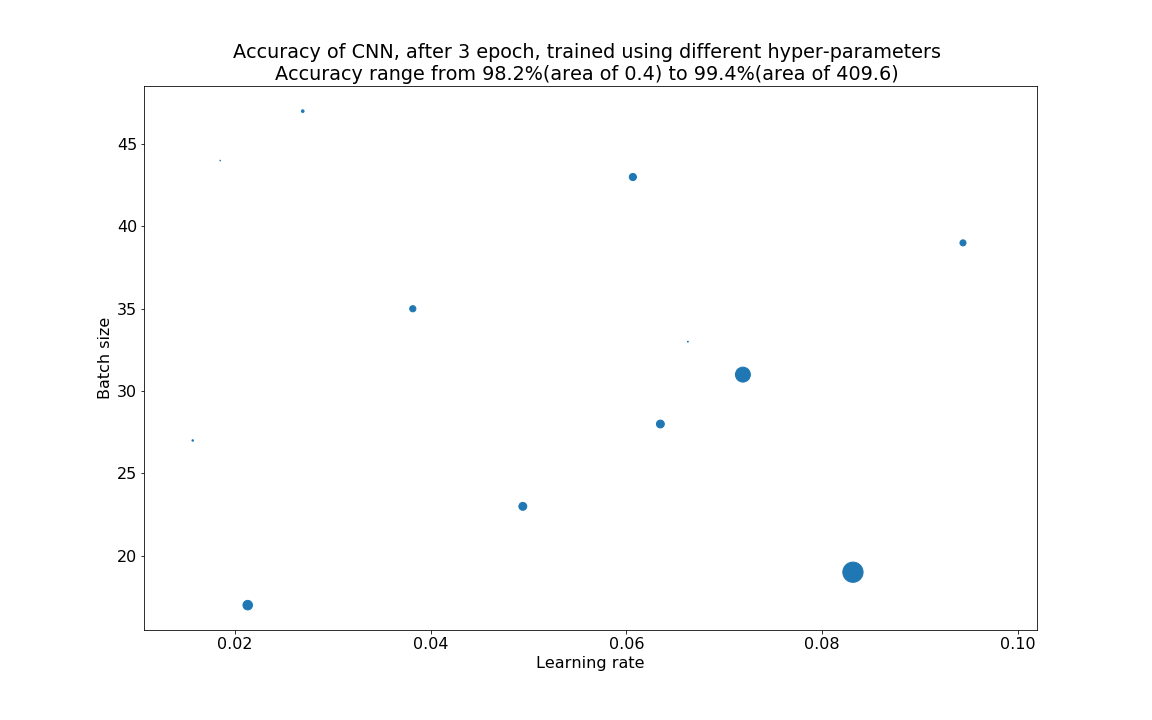

In [46]:
# Here's what we add when we runned the notebook :
# Searching hyper-parameters space using a sobol sequence using :
# start     = 2030      (the starting point in the sequence)
# nb_points = 20        (number of points to evaluate)
# lr_min = 0.01         (lower bound for learning rate)
# lr_max = 0.1          (upper bound for learning rate)
# batch_size_min =  2*8 (lower bound for batch size)
# batch_size_max =  6*8 (upper bound for batch size)
loading_path = "./output/2019February15_AM11H37M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

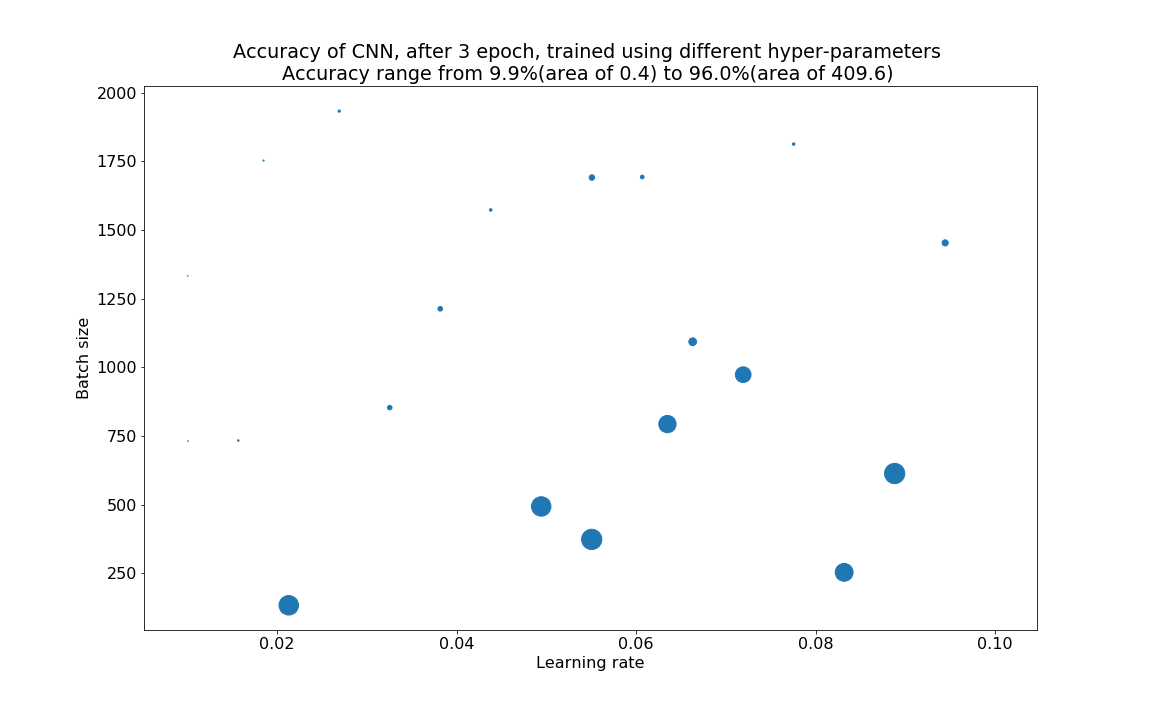

In [83]:
# Searching hyper-parameters space using a sobol sequence (see later) using :
# start     = 2030      (the starting point in the sequence)
# nb_points = 20        (number of points to evaluate)
# lr_min = 0.01         (lower bound for learning rate)
# lr_max = 0.1          (upper bound for learning rate)
# batch_size_min = 2*64 (lower bound for batch size)
# batch_size_max = 32*64(upper bound for batch size)
loading_path = "./output/2019February15_PM12H19M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

In [79]:
# instantiate CNNClassifier and load it to the gpu if possible
net_cnn = CNNClassifier()
net_cnn.apply( glorot_init )
_ = net_cnn.to(device)

In [80]:
# define the loss function as the cross entropy and choose a learning rate that works well
# Restraining ourselves to small batch size, the search found those hyper-parameters :
# lr = 0.0831689
# training_batch_size = 19
#                          with large batch size, the search found those hyper-parameters :
# lr = 0.0505483
# training_batch_size = 373

criterion = nn.CrossEntropyLoss()
lr = 0.0505483
optimizer = optim.SGD(net_cnn.parameters(), lr=lr, momentum=0.0, weight_decay=0)
nb_epoch  = 10

training_batch_size = 373
train_loader = DataLoader(train_set, batch_size=training_batch_size,shuffle=True, num_workers=2)
cnn_state_dict_list = list()        # we save (all) the intermediate state of the model during the learning phase

# average loss across epoch
cnn_avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
# accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
cnn_accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)

Just to see that all is fine : we make sure that in its current state the net is randomly guessing and has around 10% accuracy.

In [81]:
valid_batch_size = 32*64
valid_loader   = DataLoader(valid_set, batch_size=valid_batch_size,shuffle=True, num_workers=2)
start_accuracy = measure_single_accuracy( net_cnn, valid_loader )
print("Accuracy at initialization : " , start_accuracy.item() , "%" )

Accuracy at initialization :  10.199999809265137 %


In [82]:
training_phase( net_cnn, nb_epoch, criterion, optimizer, cnn_avg_loss, cnn_accuracy, train_loader, cnn_state_dict_list )

epoch =   1, loss = 2.026675 , accuracy = 43.173332
epoch =   2, loss = 0.519649 , accuracy = 83.356667
epoch =   3, loss = 0.200676 , accuracy = 93.631668
epoch =   4, loss = 0.193007 , accuracy = 94.375000
epoch =   5, loss = 0.115787 , accuracy = 96.449997
epoch =   6, loss = 0.084512 , accuracy = 97.288330
epoch =   7, loss = 0.071549 , accuracy = 97.763336
epoch =   8, loss = 0.063589 , accuracy = 98.018333
epoch =   9, loss = 0.057995 , accuracy = 98.139999
epoch =  10, loss = 0.050973 , accuracy = 98.471664
Finished Training
Time required =  76.927828125  s 


#### Measure the accuracy of the net on the dataset(s) across epoch  
We retrieve every state dictionnary on the list, load it to the net  
and compute the accuracy on the chosen dataset(s).  

In [84]:
batch_size = 32*64
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=False , num_workers=2)
valid_loader = DataLoader(valid_set , batch_size = batch_size, shuffle=False , num_workers=2)

measure_train_accuracy = False # this is already computed 
measure_valid_accuracy = True  # 

measure_accuracy( net_cnn , cnn_accuracy, train_loader, valid_loader, cnn_state_dict_list , 
                     measure_train_accuracy, measure_valid_accuracy )

epoch   1 : Accuracy of the network on the validation images: 68.90 % , training images 43.17 % 
epoch   2 : Accuracy of the network on the validation images: 92.61 % , training images 83.36 % 
epoch   3 : Accuracy of the network on the validation images: 95.71 % , training images 93.63 % 
epoch   4 : Accuracy of the network on the validation images: 95.39 % , training images 94.38 % 
epoch   5 : Accuracy of the network on the validation images: 97.09 % , training images 96.45 % 
epoch   6 : Accuracy of the network on the validation images: 97.66 % , training images 97.29 % 
epoch   7 : Accuracy of the network on the validation images: 98.10 % , training images 97.76 % 
epoch   8 : Accuracy of the network on the validation images: 97.93 % , training images 98.02 % 
epoch   9 : Accuracy of the network on the validation images: 98.29 % , training images 98.14 % 
epoch  10 : Accuracy of the network on the validation images: 98.27 % , training images 98.47 % 
Time required =  14.5150839843

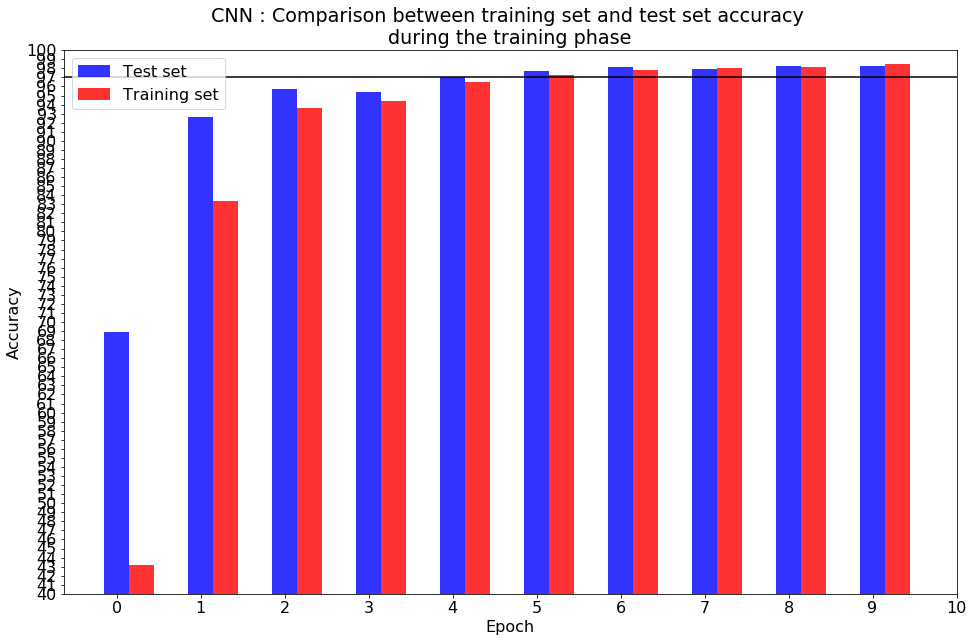

In [85]:
# Plot the accuracy
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
plot_accuracy_1d( net_cnn, lr, training_batch_size, cnn_accuracy, path_to_save, filename, "CNN : ", want_log )

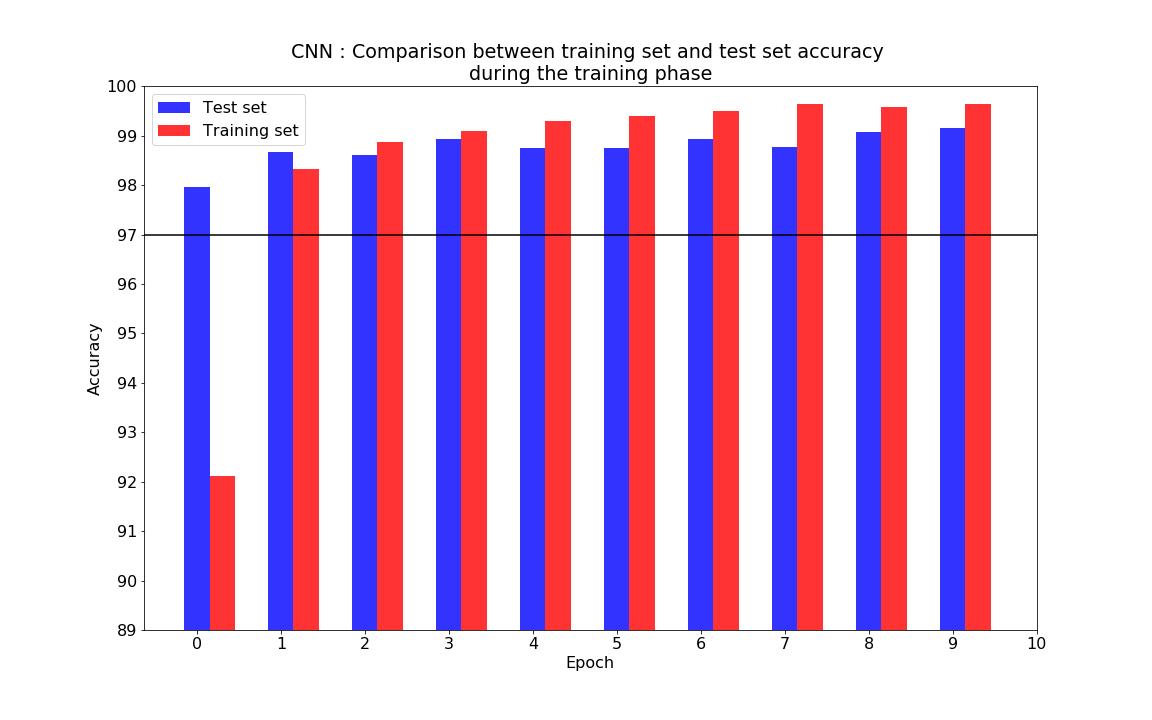

In [72]:
# Here's what we add when we runned the notebook using large batch size:
loading_path = "./output/2019February15_PM12H02M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

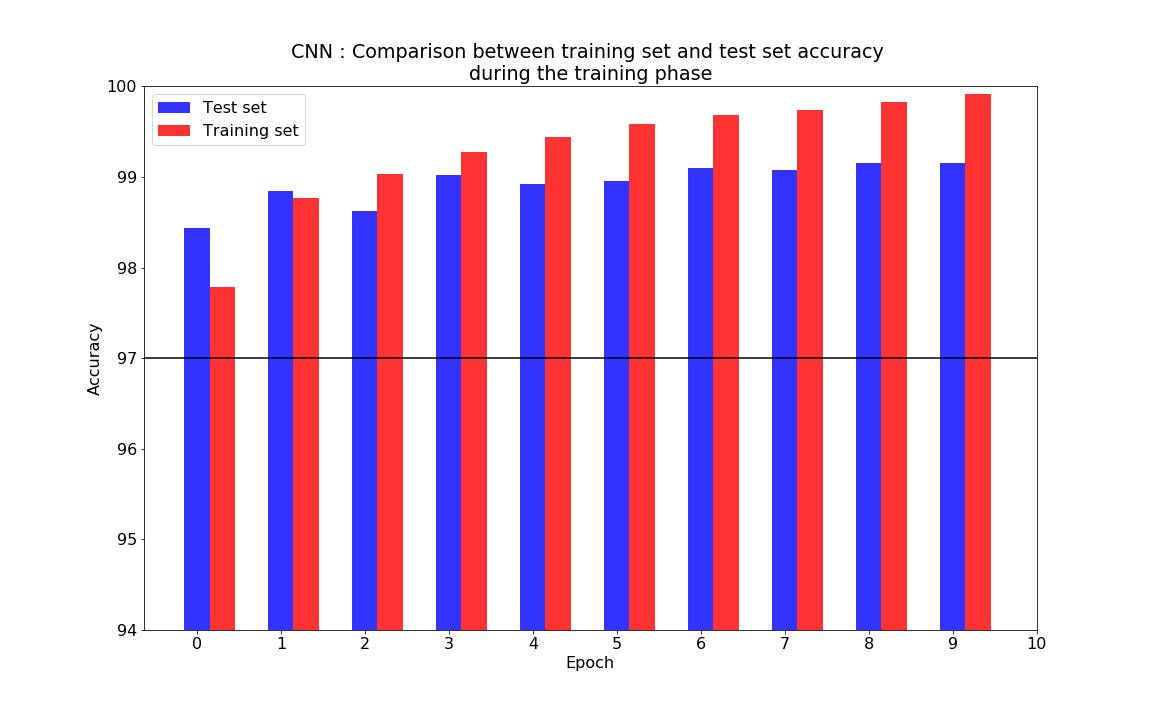

In [71]:
# Here's what we add when we runned the notebook using small batch size:
loading_path = "./output/2019February12_PM03H48M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# Train some multi-layer perceptron's (MLP's)

#### What we plan to do :  
a) We generate a pair (learning rate, batch size)  
b) We train an mlp for 3 epoch using these hyper-parameters  
c) We pick the mlp that has the highest accuracy on the validation dataset  
d) We train another mlp with the same hyper-parameters for 10 epoch  
e) We compare the performance of this mlp against the cnn  


Here's vizualisation of successive points from a 2d sobol sequence 

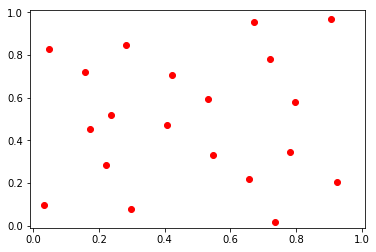

In [38]:
# Vizualize a sobol sequence
#seq = sobol_seq.i4_sobol_generate(2,32)
start     = 3030
nb_points = 20

seq = np.empty((nb_points,2))
end       = start + nb_points
for i,j in enumerate(range(start,end,1)) :
    seq[i,:] ,_ = sobol_seq.i4_sobol(2,j)

plt.plot(seq[:,0],seq[:,1], 'ro')
eps = 0.01
plt.axis([0 - eps , 1 + eps , 0 - eps , 1 + eps ])
plt.show()

In [86]:
nb_epoch  = 3

# current mlp with the best performance on the validation set, on its last epoch
acc_max = 0
idx_max = 0

# we save (all) the intermediate state of the model during the learning phase, for each mlp
state_dict_dict = dict() 

# search around a good learning rate : 0.055
# lr_min = 0.02
# lr_max = 0.10
lr_min = 0.001
lr_max = 0.1

# search around a good batch size : 2*8
# batch_size_min =  2*8
# batch_size_max =  6*8
batch_size_min =  2 *64
batch_size_max =  32*64

#
valid_batch_size = 32*64
valid_loader = DataLoader(train_set, batch_size=valid_batch_size,shuffle=False, num_workers=2)

# we started from 1030 for mlp and from 2030 for cnn
start     = 4030
nb_points = 20
valid_acc = torch.empty(nb_points)
seq = np.empty((nb_points,2))
end       = start + nb_points
for i,j in enumerate(range(start,end,1)) :   
    hyperparam_point ,_ = sobol_seq.i4_sobol(2,j)
    lr, batch_size      = hyperparam_point
    # take the point in the unitary cube and map it to the desired box
    lr         = lr*(lr_max-lr_min) +lr_min
    batch_size = math.ceil(batch_size*(batch_size_max-batch_size_min)+batch_size_min)
    
    if i != 0 :
        del net_mlp
        
    net_mlp = MLP()
    # net_mlp = CNNClassifier() # in order to search for good CNN parameters
    net_mlp.apply( glorot_init )
    _ = net_mlp.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net_mlp.parameters(), lr=lr, momentum=0.0, weight_decay=0)

    train_batch_size = batch_size
    train_loader = DataLoader(train_set, batch_size=train_batch_size,shuffle=True , num_workers=2)
    state_dict_list = list() # we save (all) the intermediate state of the model during the learning phase, for one  mlp

    # average loss across epoch
    avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
    # accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
    accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
    # print hyper-parameters 
    print("point no. {i}, lr = {lr}, batch size = {batch_size}".format(i=i, lr=lr,batch_size=batch_size))
    
    # we dump output to disable sound
    torch.cuda.synchronize()
    _ = training_phase( net_mlp, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, state_dict_list )
    state_dict_dict[i] = [[lr,batch_size],state_dict_list,avg_loss,accuracy]
    
    
    valid_accuracy = measure_single_accuracy(net_mlp,valid_loader)
    valid_acc[i] = valid_accuracy
    if valid_accuracy > acc_max :
        acc_max = valid_accuracy
        idx_max = i
    torch.cuda.synchronize()

print("#####################")
print("best net found : {i} , with validation accuracy = {va}".format(i=idx_max,va=acc_max.item()))
Audio(wave, rate=10000, autoplay=True)

point no. 0, lr = 0.052844482421875005, batch size = 301
epoch =   1, loss = 0.737449 , accuracy = 82.238335
epoch =   2, loss = 0.327516 , accuracy = 90.846664
epoch =   3, loss = 0.273621 , accuracy = 92.343330
Finished Training
Time required =  14.309042968750001  s 
point no. 1, lr = 0.003344482421875, batch size = 1261
epoch =   1, loss = 2.311494 , accuracy = 15.796667
epoch =   2, loss = 2.175707 , accuracy = 36.203335
epoch =   3, loss = 2.050641 , accuracy = 53.508335
Finished Training
Time required =  16.625027343750002  s 
point no. 2, lr = 0.002571044921875, batch size = 586
epoch =   1, loss = 2.242855 , accuracy = 23.833334
epoch =   2, loss = 2.026978 , accuracy = 54.400002
epoch =   3, loss = 1.822500 , accuracy = 66.923332
Finished Training
Time required =  15.893194335937501  s 
point no. 3, lr = 0.052071044921875004, batch size = 1546
epoch =   1, loss = 1.610552 , accuracy = 67.438332
epoch =   2, loss = 0.749147 , accuracy = 84.736664
epoch =   3, loss = 0.526308 ,

#### Display the results from the search  
  

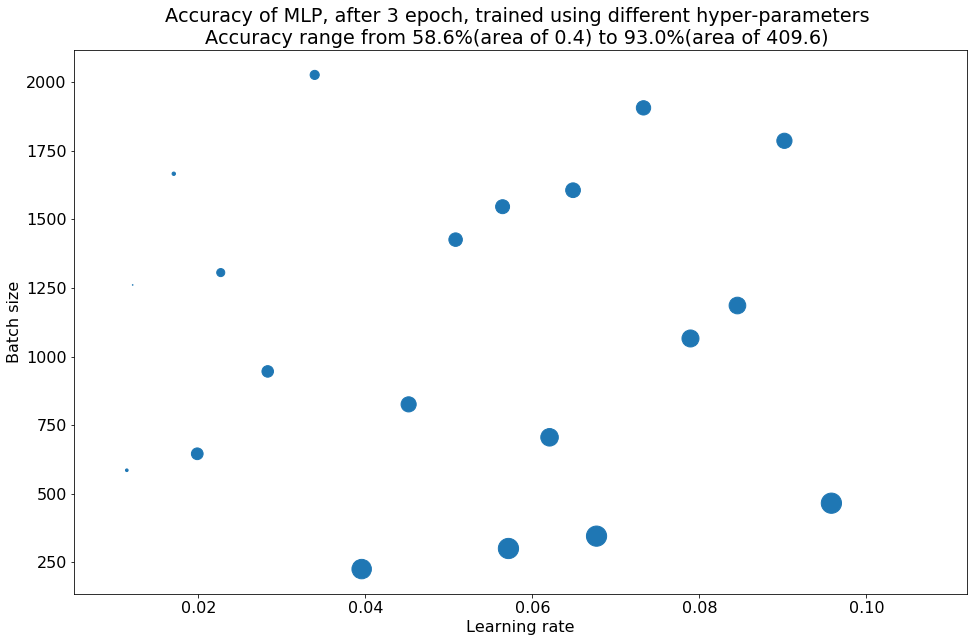

In [88]:
# taken from
# https://matplotlib.org/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

# search around a good learning rate : 0.055
lr_min = 0.01
lr_max = 0.1

# search around a good batch size : 2*8
# batch_size_min =  2*8
# batch_size_max =  6*8
batch_size_min =  2 *64
batch_size_max =  32*64

# Fixing start state for reproducibility
start     = 4030
nb_points = 20
end       = start + nb_points
_x = torch.empty(nb_points)
_y = torch.empty(nb_points) 
for i,j in enumerate(range(start,end,1)) :   
    hyperparam_point ,_ = sobol_seq.i4_sobol(2,j)
    lr, batch_size      = hyperparam_point
    # take the point in the unitary cube and map it to the desired box
    lr         = lr*(lr_max-lr_min) +lr_min
    batch_size = math.ceil(batch_size*(batch_size_max-batch_size_min)+batch_size_min)
    _x[i] = lr
    _y[i] = batch_size

N = nb_points
_val = valid_acc
val = _val.numpy()
val = val - val.min()
val = val / val.max() 
x = _x.numpy()
y = _y.numpy()
# colors = np.ones(N)*(0.2)
area = 0.4*(1+val)**10

str_title1 = "Accuracy of MLP, after {epoch} epoch, trained using different hyper-parameters \n".format(epoch=nb_epoch)
str_title2 = "Accuracy range from {min:.{prec}f}%(area of {rmin:.{prec}f}) to {max:.{prec}f}%(area of {rmax:.{prec}f}) ".format(
      min  = torch.min(valid_acc).item(),
      rmin = area.min(),
      max  = torch.max(valid_acc).item(),
      rmax = area.max(),
      prec = 1
    )
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (16,10)
    
plt.title(str_title1+str_title2)
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
    
plt.scatter(x, y, s=area)
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
if want_log :
        plt.savefig(path_to_save + filename + ".png")   
plt.show()

#### What we had when we runned the notebook

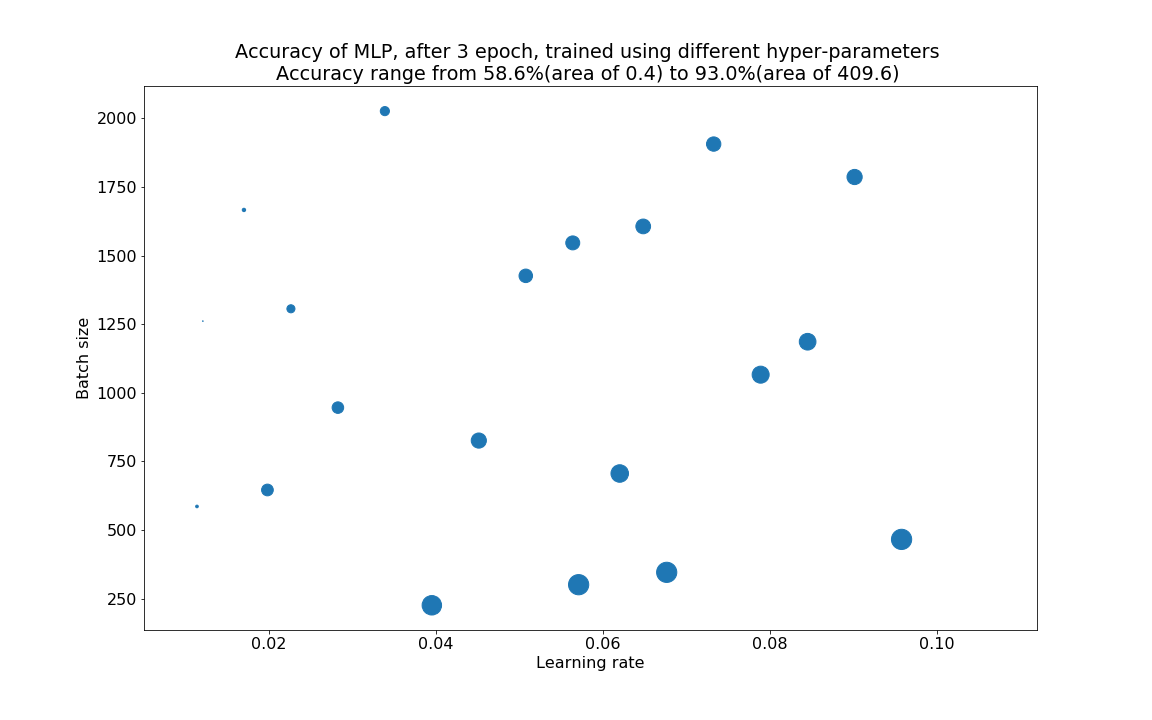

In [137]:
# Here's what we add when we runned the notebook :
# Searching hyper-parameters space using a sobol sequence using :
# start     = 4030      (the starting point in the sequence)
# nb_points = 20        (number of points to evaluate)
# lr_min = 0.01         (lower bound for learning rate)
# lr_max = 0.1          (upper bound for learning rate)
# batch_size_min =   2*64(lower bound for batch size)
# batch_size_max =  32*64(upper bound for batch size)
loading_path = "./output/2019February15_PM12H36M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

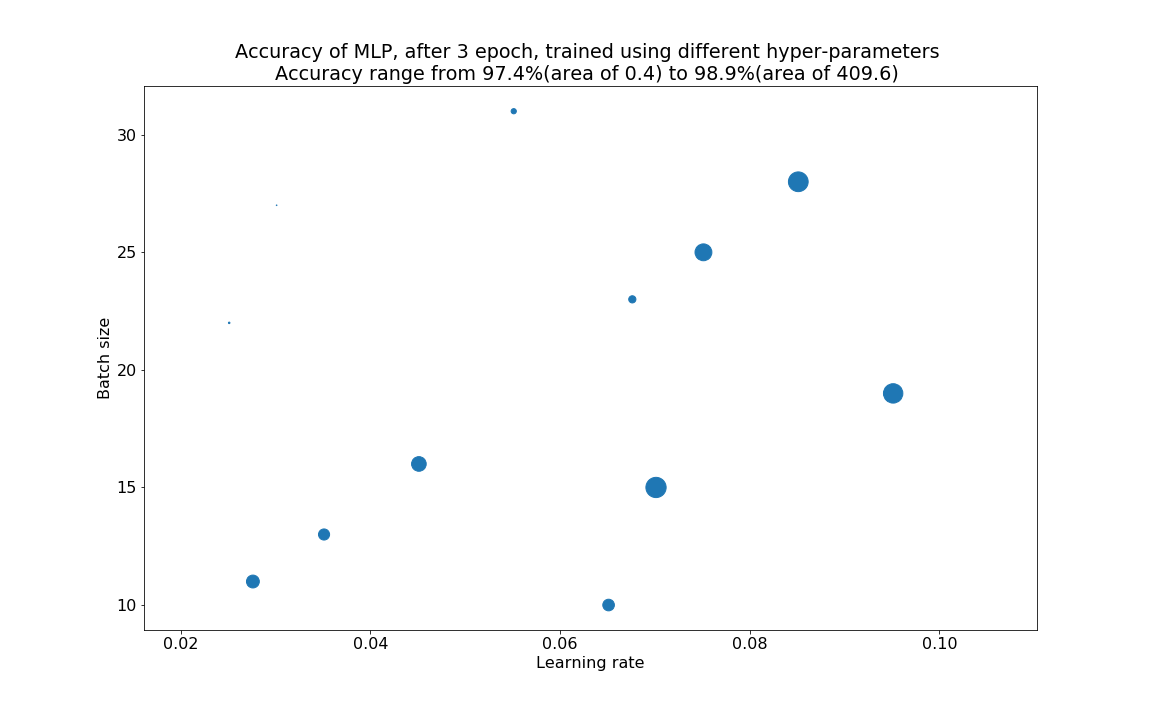

In [138]:
# Here's what we add when we runned the notebook :
# Searching hyper-parameters space using a sobol sequence using :
# start     = 2030      (the starting point in the sequence)
# nb_points = 12        (number of points to evaluate)
# lr_min = 0.01         (lower bound for learning rate)
# lr_max = 0.1          (upper bound for learning rate)
# batch_size_min =  2*8 (lower bound for batch size)
# batch_size_max =  6*8 (upper bound for batch size)
loading_path = "./output/2019February12_PM05H03M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

### Take what seems to be the best choice of hyper-parameters and train an mlp  


#### Training

In [99]:
# retrieve the best performing mlp
# In our run, we got (with small batch size):
#                      - lr_mlp = 0.070 (learning rate)
#                      - bs_mlp = 15    (batch size)
#                    (with large batch size):
#                      - lr_mlp = 0.0953835 (learning rate)
#                      - bs_mlp = 466       (batch size)

(lr_mlp,bs_mlp),mlp_dict,mlp_avg_loss,mlp_accuracy = state_dict_dict[idx_max]
net_best_mlp = MLP()
_ = net_best_mlp.to(device)

# 
nb_epoch  = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_best_mlp.parameters(), lr=lr_mlp, momentum=0.0, weight_decay=0)
train_loader = DataLoader(train_set, batch_size=bs_mlp,shuffle=True, num_workers=2)
mlp_dict = list()
mlp_avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
mlp_accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
training_phase( net_best_mlp, nb_epoch, criterion, optimizer, mlp_avg_loss, mlp_accuracy, train_loader, mlp_dict )

epoch =   1, loss = 1.318615 , accuracy = 71.245003
epoch =   2, loss = 0.427305 , accuracy = 88.176666
epoch =   3, loss = 0.338193 , accuracy = 90.449997
epoch =   4, loss = 0.298871 , accuracy = 91.448334
epoch =   5, loss = 0.268345 , accuracy = 92.338333
epoch =   6, loss = 0.245067 , accuracy = 93.016670
epoch =   7, loss = 0.224851 , accuracy = 93.583336
epoch =   8, loss = 0.205844 , accuracy = 94.206665
epoch =   9, loss = 0.189423 , accuracy = 94.618332
epoch =  10, loss = 0.175385 , accuracy = 95.051666
Finished Training
Time required =  47.32427734375  s 


#### Measure its accuracy

In [100]:
measure_train_accuracy = False # this is already computed 
measure_valid_accuracy = True  # 

batch_size = 16*64
valid_loader = DataLoader(valid_set , batch_size = batch_size, shuffle=False , num_workers=2)

measure_accuracy( net_best_mlp , mlp_accuracy, train_loader, valid_loader, mlp_dict , 
                     measure_train_accuracy, measure_valid_accuracy )

epoch   1 : Accuracy of the network on the validation images: 86.58 % , training images 71.25 % 
epoch   2 : Accuracy of the network on the validation images: 90.20 % , training images 88.18 % 
epoch   3 : Accuracy of the network on the validation images: 91.18 % , training images 90.45 % 
epoch   4 : Accuracy of the network on the validation images: 92.40 % , training images 91.45 % 
epoch   5 : Accuracy of the network on the validation images: 92.60 % , training images 92.34 % 
epoch   6 : Accuracy of the network on the validation images: 93.44 % , training images 93.02 % 
epoch   7 : Accuracy of the network on the validation images: 94.06 % , training images 93.58 % 
epoch   8 : Accuracy of the network on the validation images: 94.28 % , training images 94.21 % 
epoch   9 : Accuracy of the network on the validation images: 94.80 % , training images 94.62 % 
epoch  10 : Accuracy of the network on the validation images: 94.99 % , training images 95.05 % 
Time required =  13.5825322265

#### Plot the accuracy of mlp across epoch

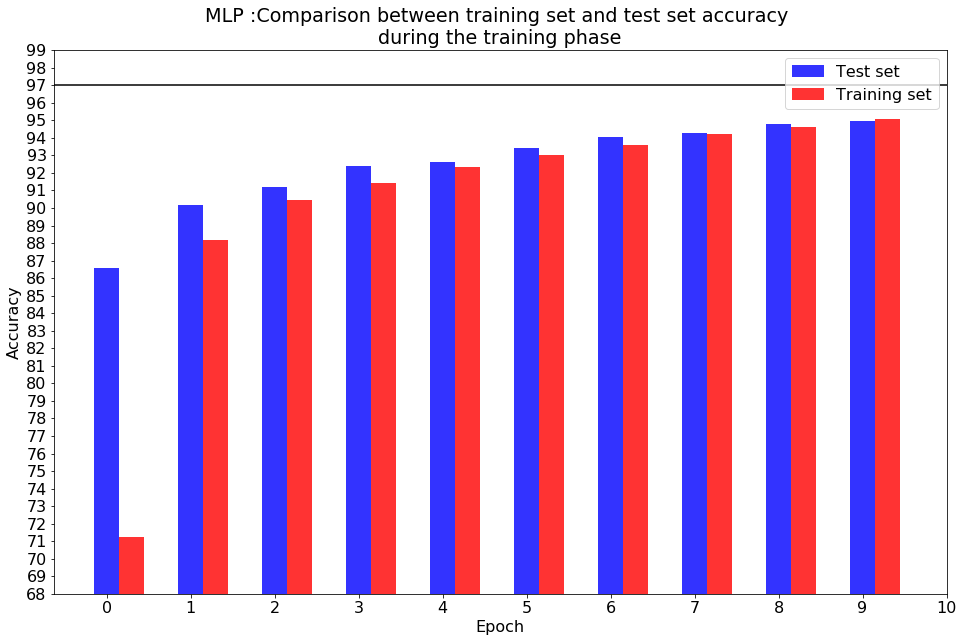

In [101]:
# Plot the accuracy
want_log     = False
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
# plot_accuracy( mlp_accuracy, want_log , path_to_save, filename )
plot_accuracy_1d( net_best_mlp, lr_mlp, bs_mlp, mlp_accuracy, path_to_save, filename , "MLP :", want_log)

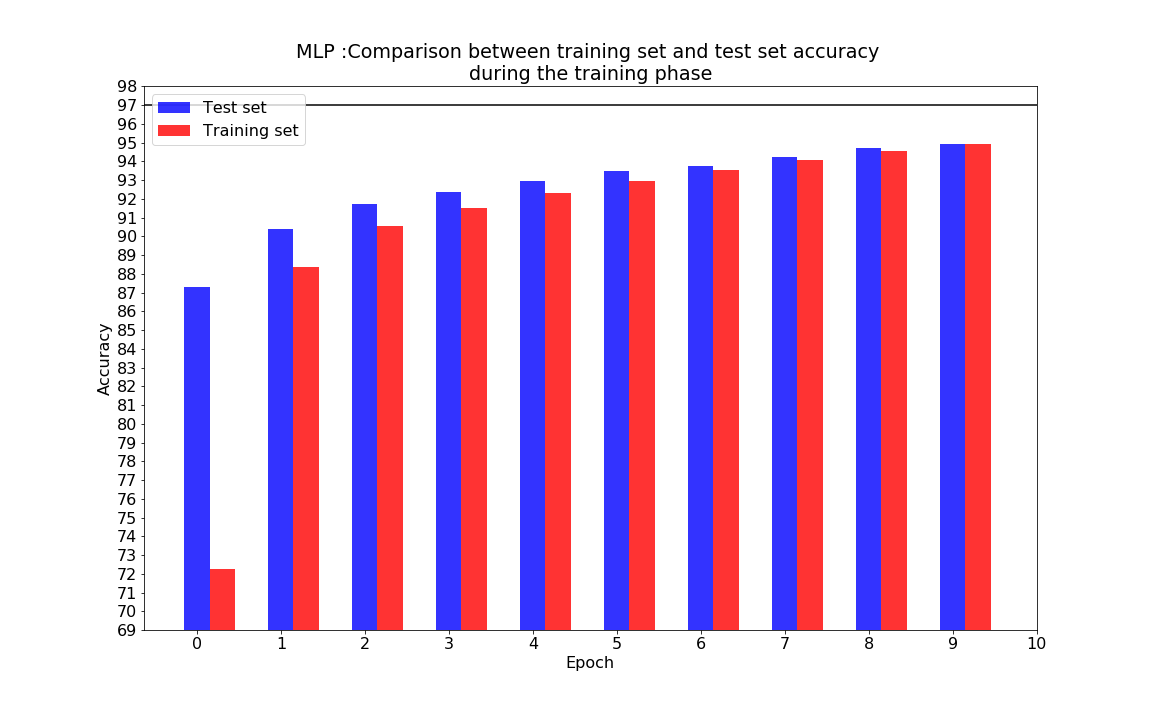

In [93]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February15_PM12H39M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

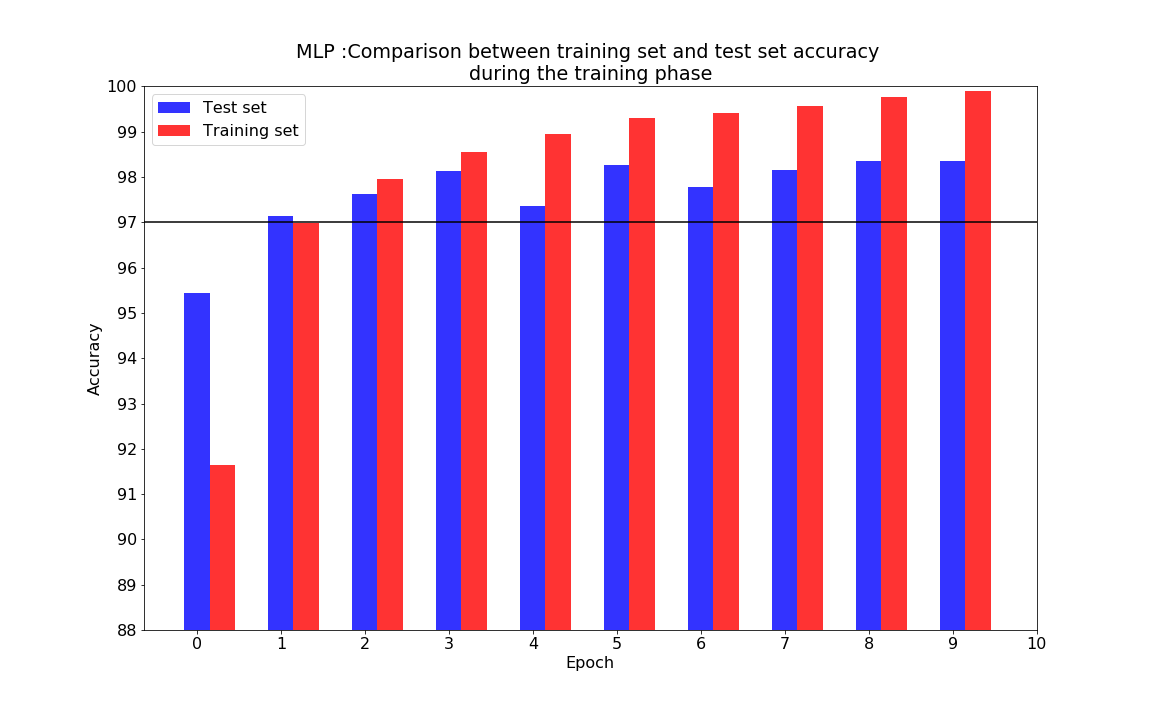

In [98]:
# Here's what we add when we runned the notebook with small batch size:
loading_path = "./output/2019February15_PM12H49M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

### Compare the performance of the mlp and the cnn on both dataset  


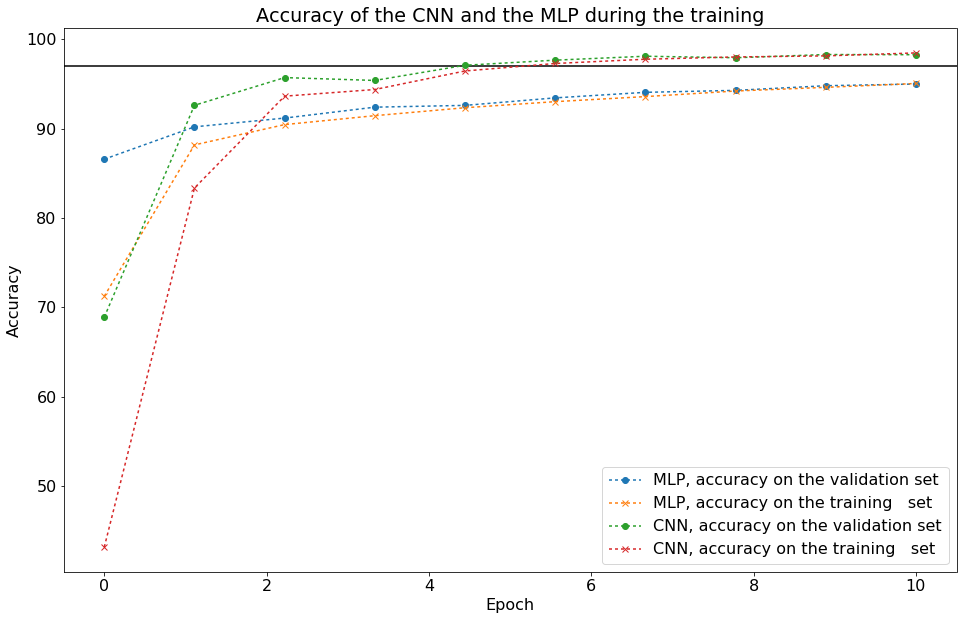

In [102]:
# nb_epoch =  cnn_accuracy.size()[0]
nb_epoch = 10
x = np.linspace(0, nb_epoch, nb_epoch)
y1a = copy.deepcopy(mlp_accuracy[:,1]).cpu().numpy()
y1b = copy.deepcopy(mlp_accuracy[:,0]).cpu().numpy()
y2a = copy.deepcopy(cnn_accuracy[:,1]).cpu().numpy()
y2b = copy.deepcopy(cnn_accuracy[:,0]).cpu().numpy()

fig, ax = plt.subplots()

line1a_label = "MLP, accuracy on the validation set"
line1b_label = "MLP, accuracy on the training   set"
line2a_label = "CNN, accuracy on the validation set"
line2b_label = "CNN, accuracy on the training   set"

plt.axhline(y=97,color="black")

line1a, = ax.plot(x, y1a, "o-", label=line1a_label)
line1a.set_dashes([2, 2])  # 2pt line, 2pt break

line1b, = ax.plot(x, y1b, "x-", label=line1b_label)
line1b.set_dashes([2, 2])  # 2pt line, 2pt break

line2a, = ax.plot(x, y2a, "o-", label=line2a_label)
line2a.set_dashes([2, 2])  # 2pt line, 2pt break

line2b, = ax.plot(x, y2b, "x-", label=line2b_label)
line2b.set_dashes([2, 2])  # 2pt line, 2pt break

str_title1 = "Accuracy of the CNN and the MLP during the training"
plt.title(str_title1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ax.legend()
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
if want_log :
        plt.savefig(path_to_save + filename + ".png")   
plt.show()

# Comparison of accuracy 

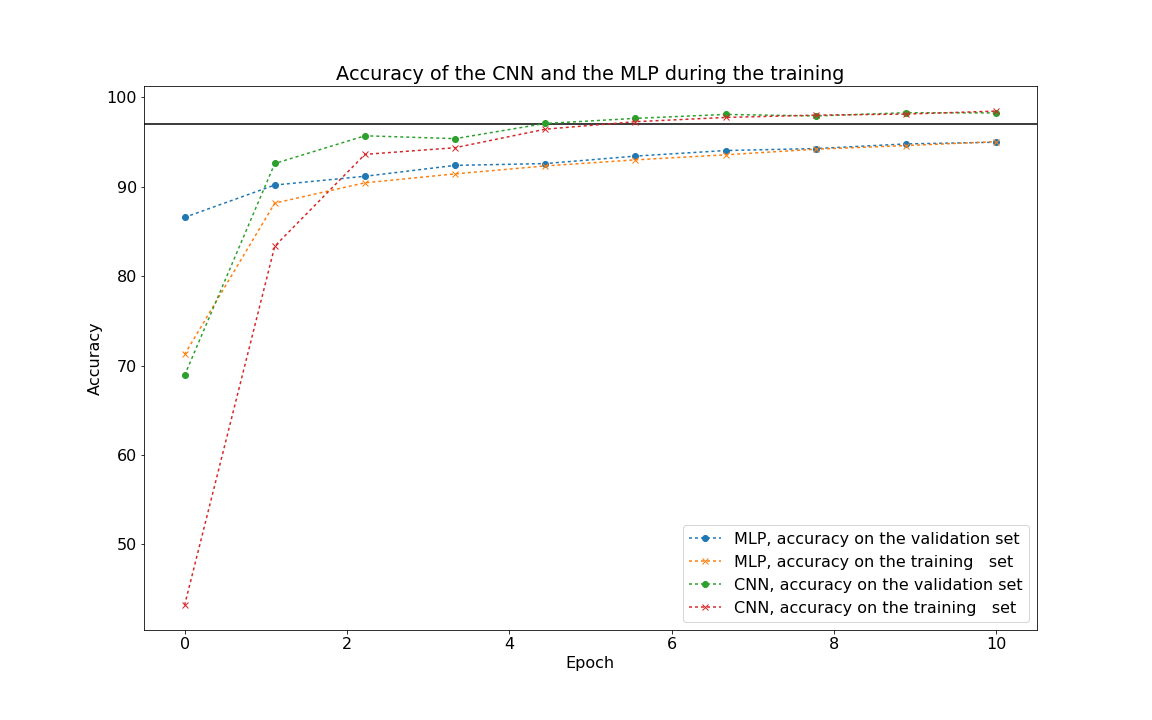

In [103]:
# Here's what we add when we runned the notebook (with large batch size):
loading_path = "./output/2019February15_PM12H52M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

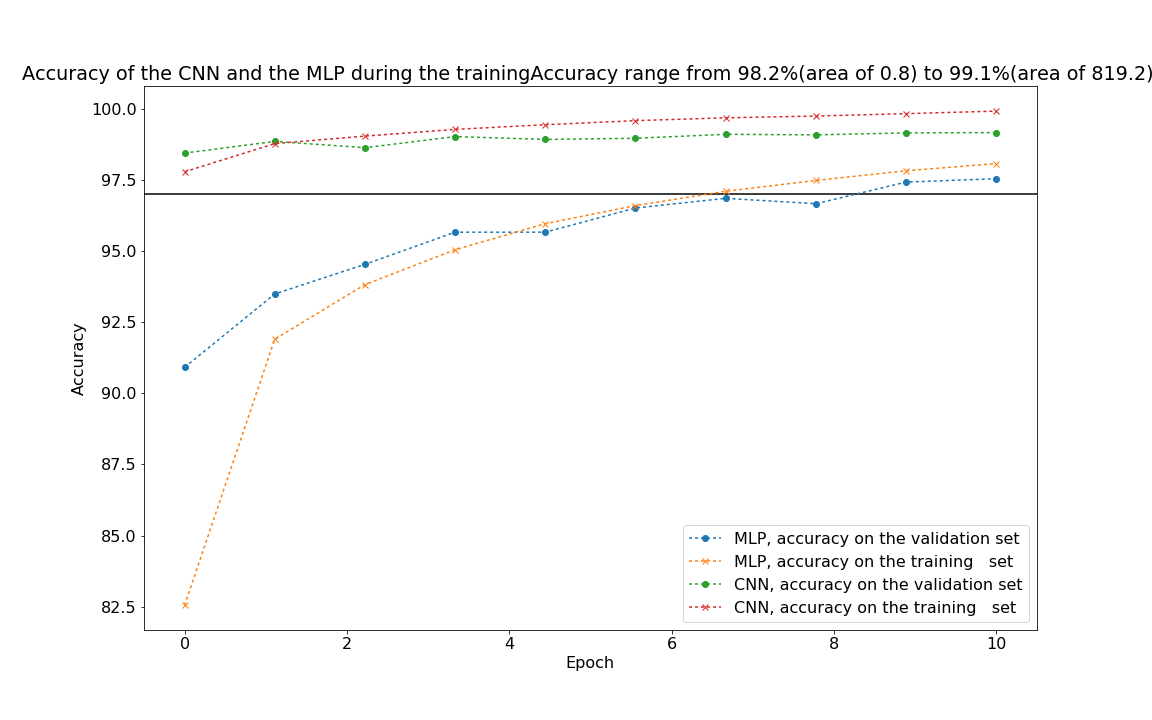

In [96]:
# Here's what we add when we runned the notebook (with small batch size): 
loading_path = "./output/2019February12_PM03H53M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

## Comparing the models

##### k-best Error : having the right label in the net's top k answers count as a good answer  
We measure errors

In [139]:
batch_size = 32*64
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2)
net_list = [net_cnn,net_best_mlp]
acc      = np.empty(2)
for n,net in enumerate(net_list,0) :
    k = 1
    correct = torch.tensor([0], device=device)
    total   = torch.tensor([0], device=device)
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.topk(outputs.data, k)[1]
            total += labels.size(0)
            for i in range(k) :
                correct += (predicted[:,i] == labels).sum()
        acc[n] = 100 - (100 * correct.double() / total.double()).item()

    print('{name} \n{k}-best Error of the network on the {nb} test images: {acc:.3f} %'.format(
                name= net.__doc__,
                k   = k,
                nb  = valid_dataset_size,
                acc = acc[n]
         ))
print("\n")
print("Relative difference = {diff:.2f} %".format( diff=100*abs(acc[0]-acc[1])/acc[0] ) )


    CNN Classifier
     
1-best Error of the network on the 10000 test images: 1.730 %

    MLP with 2 hidden layer
     
1-best Error of the network on the 10000 test images: 5.010 %


Relative difference = 189.60 %


When we run the last cell, we obtain :  
- a relative difference of 189.60 % for k=1  
- a relative difference of 443.75 % for k=2  
- a relative difference of 492.31 % for k=3  
- a relative difference of 1750.0 % for k=4  
- a relative difference of inf %    for k=5  
  
Which means that the cnn has better 1st, 2nd, 3rd, 4th and 5th options than the mlp (and is making no mistakes with k=5).


# The interesting part of the notebook ends here

### Save and load models  
With the following code, you can load the models we obtained when we runned the notebook and save your models.

In [140]:
local_path = "./save/export/"

# save current mlp states only
mynet = copy.deepcopy(net_best_mlp).cpu()
saving_name = "net_best_mlp.pth"
state_dict_to_disk = mynet.state_dict()
torch.save( state_dict_to_disk , local_path + saving_name)

# save current cnn states only
mynet = copy.deepcopy(net_cnn).cpu()
saving_name = "net_cnn.pth"
state_dict_to_disk = mynet.state_dict()
torch.save( state_dict_to_disk , local_path + saving_name)

In [141]:
local_path = "./save/export/"

# load mlp final state only
loading_name = "net_best_mlp.pth" # MLP()
mynet = MLP()
mynet.load_state_dict(torch.load(local_path + loading_name))
net_best_mlp = copy.deepcopy( mynet ).to(device)

# load cnn final state only
loading_name = "net_cnn.pth" # MLP()
mynet = CNNClassifier()
mynet.load_state_dict(torch.load(local_path + loading_name))
net_cnn = copy.deepcopy( mynet ).to(device)